# UserClassifier: Use machine learning to segment users and predict user retention

The goal of the project is to analyze the existing user base in one of the health apps my consulting company built and segment them into groups that predict user activity, and then construct a predictive model to assess parameters that most likely contribute to user activity prediction.

This code is the first step that reads user login data from 'UserLog.csv', organizes it, and extracts features from this time series data to be used in later clustering step.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import time
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters

## Load dataset

In [2]:
#Load user login data and user data that indicates the role of users.
userlog = pd.read_csv('UserLog.csv')
userdata = pd.read_csv('User.csv')
#Choose login data of only users.
userid = userdata[userdata['role']=='user']
user = userlog[userlog['user'].isin(userid['_id'])]
#Since the app launch in Aug 1st, choose login data after Aus 1st.
user = user[user['dateValue']>'2019-08-01 00:00:00.000+00']
#Describe the total number of logins of each user
user_count = user['user'].value_counts()
user_count.describe()

count    5637.000000
mean       22.581515
std        39.544985
min         1.000000
25%         3.000000
50%         6.000000
75%        28.000000
max       689.000000
Name: user, dtype: float64

## Visualize the distribution of user logins

Text(0, 0.5, 'Number of users')

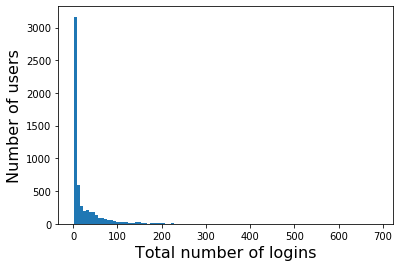

In [3]:
#Plot the distribution of the total number of logins of users. 
#Most users just log in the app once since it is a new app.
#X-axis is the number of logins, and y-axis is the number of users
plt.hist(user_count,bins=100)
plt.xlabel("Total number of logins", fontsize=16)  
plt.ylabel("Number of users", fontsize=16)

In [5]:
#Describe the number of logins per day.
user.loc[:,'date'] = pd.to_datetime(user.loc[:,'dateValue'])
date_count = user['date'].dt.date.value_counts()
date_count.describe()

count      50.000000
mean     2545.840000
std      1231.725956
min       166.000000
25%      1610.500000
50%      3083.000000
75%      3514.750000
max      4385.000000
Name: date, dtype: float64

Text(0, 0.5, 'Number of logins')

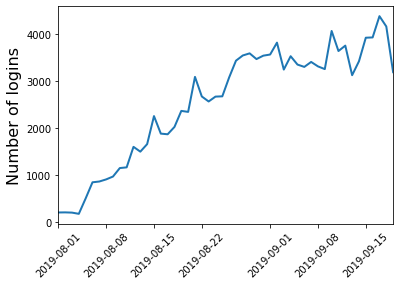

In [6]:
#Plot the distribution of the number of logins per day.
#The number of logins increased a lot in Aug, but remains the stable in Sep.
date_count.plot(linewidth=2)
plt.xticks(rotation=45)
plt.ylabel("Number of logins", fontsize=16)

## Visualize the distribution of app usage duration

                                     min_login_date max_login_date  interval
user                                                                        
00000000-579f-f5c5-aa50-e8f732c1ba9a     2019-08-02     2019-09-14        43
00000000-584d-a4f0-bdee-d4102b989ce5     2019-08-12     2019-08-19         7
00000000-584e-1f39-bdee-d4102b989d01     2019-08-01     2019-09-19        49
00000000-5854-8d6f-b8eb-cf14a0f795df     2019-09-16     2019-09-18         2
00000000-58a9-1d41-486e-ac71001b7163     2019-08-01     2019-08-23        22
...                                             ...            ...       ...
ffc3a5fc-061d-4bdd-aefe-ed06aadad483     2019-09-05     2019-09-05         0
ffd3b623-814c-42d2-928f-add9bdf3ec61     2019-08-18     2019-08-18         0
ffdb10b1-624e-436b-b8ab-ee99d8347784     2019-09-15     2019-09-19         4
ffea4e7a-4469-4cee-aad3-115f785c5a62     2019-09-18     2019-09-19         1
ffff693b-9493-487a-90f4-d1709acadaef     2019-08-08     2019-09-10        33

Text(0, 0.5, 'Number of users')

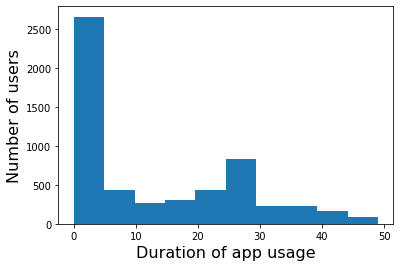

In [10]:
#Calculate the duration of app usage of each users. 
#Most users doesn't use the app long because the it is a new app.
user['dateValue'] = pd.to_datetime(user['dateValue'])
user['day'] = user['dateValue'].dt.strftime("%D")
day = user.groupby(['user','day']).type.count().reset_index()
# Ensure 'day' column has correct datetime type
day['day'] = pd.to_datetime(day['day'])
# Need to create dummy interval for new aggregated column using lambda to avoid no index error
day['interval']=day['day']
#Calculate min and max of login date and the intervals between min and max as duration of app usage
user_login_interval= day.groupby('user').agg(
    min_login_date=pd.NamedAgg(column='day', aggfunc='min'),
    max_login_date=pd.NamedAgg(column='day', aggfunc='max'),
    interval=pd.NamedAgg(column='interval', aggfunc=lambda x: (x.max() - x.min()).days),
)
print(user_login_interval)

interval = user_login_interval.reset_index()[['user','interval']]
plt.hist(user_login_interval['interval'])
plt.xlabel("Duration of app usage", fontsize=16)  
plt.ylabel("Number of users", fontsize=16)

## Extract features from login data

In [11]:
#Get the hours which users logged in the app as a feature to segment users
user['hour'] = user['dateValue'].dt.strftime("%H")
hour = user.groupby(['user','hour']).type.count().reset_index()
user_hour= hour.iloc[hour.groupby(['user'])['type'].idxmax()]
hr_mode = user_hour [['user','hour']]
hr_mode.head()

,user,hour
0,00000000-579f-f5c5-aa50-e8f732c1ba9a,00
11,00000000-584d-a4f0-bdee-d4102b989ce5,19
23,00000000-584e-1f39-bdee-d4102b989d01,14
37,00000000-5854-8d6f-b8eb-cf14a0f795df,21
38,00000000-58a9-1d41-486e-ac71001b7163,03


In [12]:
#Resample the login data to set login intervals to be one day
login_info = user.groupby([pd.Grouper(key='dateValue', freq="1D"),'user']).type.count()
login = login_info.reset_index()
login.rename(columns={'type':'logins'},
                 inplace=True)

In [13]:
#I use tsfresh to extract features from user login data.
#User login data is time series data. And tsfresh calculates different characteristics,
#such as the maximal or minimal, average temperature or the number of peaks automatically.
X_tsfresh = extract_features(login, column_id= 'user', column_value='logins', default_fc_parameters=EfficientFCParameters())
login_feature = X_tsfresh.reset_index()

Feature Extraction: 100%|██████████| 10/10 [05:39<00:00, 33.92s/it]


In [15]:
#Save all the features extracted from user login data to be used in the clustering step.
user_login = pd.merge(login_feature, hr_mode, how='outer', on=['user'])
user_login = pd.merge(user_login, interval, how='outer', on=['user'])
user_login.to_csv('user_log_new.csv')